# Westeros Introducing emissions: Changing emission bounds to 250 MtCO2

In the second part, with emission bound 500 MtCO2, the model chose not to base the power system on wind power as electricity from wind turbines is more expensive than electricity produced from coal and solar panels. However, now we limit emissions even further to see if wind will be included in the energy mix.

**Pre-requisites**
- You have the *MESSAGEix* framework installed and working
- You have run Westeros baseline scenario (``westeros_baseline.ipynb``) and solved it successfully

In [1]:
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

## Making a clone of the existing scenario 'baseline'

In [3]:
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="solar_power")
scen = base.clone(
    model,
    "emission_bound",
    "introducing an upper bound on emissions",
    keep_solution=False,
)
scen.check_out()

In [4]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

## Introducing Emissions

In [5]:
# First we introduce the emission of CO2 and the emission category GHG
scen.add_set("emission", "CO2")
scen.add_cat("emission", "GHG", "CO2")

# Then we add new units to the model library (needed only once)
mp.add_unit("tCO2/kWa")
mp.add_unit("MtCO2")

# Last we add CO2 emissions to the coal powerplant
emission_factor = make_df(
    "emission_factor",
    node_loc=country,
    year_vtg=vintage_years,
    year_act=act_years,
    mode="standard",
    unit="tCO2/kWa",
    technology="coal_ppl",
    emission="CO2",
    value=7.4
)
scen.add_par("emission_factor", emission_factor)

## Define a Bound on Emissions

The `"type_year": "cumulative"` assigns an upper bound on the *weighted average of emissions* over the entire time horizon.

In [6]:
scen.add_par(
    "bound_emission", [country, "GHG", "all", "cumulative"], value=250.0, unit="MtCO2"
)

## Time to Solve the Model

In [7]:
scen.commit(comment="Introducing emissions and setting an upper bound")
scen.set_as_default()

In [8]:
scen.solve()

In [9]:
scen.var("OBJ")["lvl"]

252721.1875

## Plotting Results

In [10]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

rep = Reporter.from_scenario(scen)
prepare_plots(rep)

### Activity

How much energy is generated in each time period from the different potential sources?

<AxesSubplot:title={'center':'Westeros Energy System Activity'}, xlabel='Year', ylabel='GWa'>

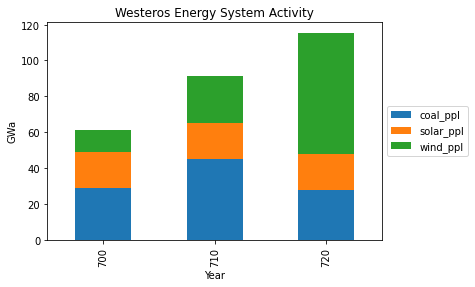

In [11]:
rep.set_filters(t=["coal_ppl", "wind_ppl", "solar_ppl"])
rep.get("plot activity")

### Capacity

How much capacity of each plant is installed in each period?

<AxesSubplot:title={'center':'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

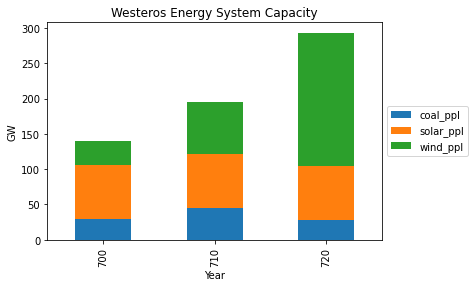

In [12]:
rep.get("plot capacity")

### Electricity Price

And how much does the electricity cost? These prices are in fact **shadow prices** taken from the **dual variables** of the model solution. They reflect the marginal cost of electricity generation (i.e., the additional cost of the system for supplying one more unit of electricity), which is in fact the marginal cost of the most expensive generator.  

<AxesSubplot:title={'center':'Westeros Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

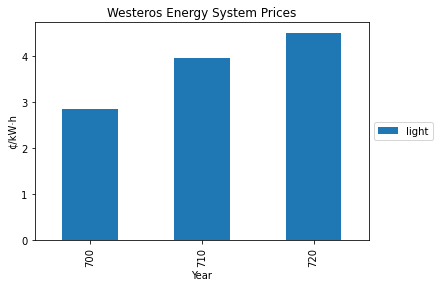

In [13]:
rep.set_filters(t=None, c=["light"])
rep.get("plot prices")

## Close the connection to the database

In [14]:
mp.close_db()

**ANALYSIS**

With an even stricter emission bound, 250 MtCO2, all three types of power sources are part of the energy mix in 720. Now wind must be included because the solar power plants are not able to grow enough in numbers in time, because of the growth bounds in the model. This is what I expected, e mixed energy mix. Because it is not practically possible to go from almost only coal power to only solar power in just 30 years. But the emission bounds had to be very low for wind to be forces into the mix. Now we also have higher electricity costs, since wind power has such high investment costs. This seems to be inevitable, that prices will rise. But some of these costs could be covered by introducing higher taxes and fees for fossil-fuel based energy sources.

I think that the model needs to be adjusted a bit as solar power is not able to grow, it just stays the same in the three time periods. It should be able to grow, as more solar power plants are built. But now it seems like an investment is made in year 700 and then no more solar power plants are built. There must be some kind of growth factor that could be included in the model so that it can grow.